# COVID-19 Health Policies
*** For specific Countries ***
(Australia, Senegal, Egypt, China)


## Import required modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Read in data

In [2]:
# Read in the data
epi_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv", 
                       keep_default_na=False, na_values=[""], parse_dates=['date'], index_col=['date'])

gr_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/oxford-government-response.csv",
                      keep_default_na=False, na_values=[""], parse_dates=['date'], index_col=['date'])

demo_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/demographics.csv", 
                       keep_default_na=False, na_values=[""])

xls = pd.ExcelFile("https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/timeseries/OxCGRT_timeseries_all.xlsx")
fc_data = pd.read_excel(xls, 'h6_facial_coverings')

## Get Specific Country Dataframes to work with
* Need epidemiology dataframe for each country
* Need government response dataframe for each country

In [3]:
# Country Codes 
# Can be found by googling "ISO 3166-1 for *countryName*"
# Australia - 'AU'
# United States - 'US'
# Senegal - 'SN'
# China - 'CN'
# Egypt - 'EG'

start_remove = ('2019-12-30')
end_remove = ('2019-12-31')
epi_data = epi_data.loc[(epi_data.index < start_remove) | (epi_data.index > end_remove)]

def preprocess_fc_data(data):
    data.columns = ['face_covering']
    data.index.name = 'date'
    data.index = pd.to_datetime(data.index)
    return data

def preprocess_data(epi_data, gr_data, demo_data, fc_data, code1, code2):
    epi_df = epi_data[(epi_data.key) == code1]
    gr_df = gr_data[(gr_data.key) == code1]
    fc_df = fc_data[(fc_data.country_code) == code2].drop(columns=['country_code', 'country_name']).T
    fc_df = preprocess_fc_data(fc_df)
    demo_df = demo_data[(demo_data.key == code1)]
    return epi_df, gr_df, fc_df, demo_df

us_epi_df, us_gr_df, us_fc_df, us_demo_df = preprocess_data(epi_data, gr_data, demo_data, fc_data, 'US', 'USA')
au_epi_df, au_gr_df, au_fc_df, au_demo_df = preprocess_data(epi_data, gr_data, demo_data, fc_data, 'AU', 'AUS')
sn_epi_df, sn_gr_df, sn_fc_df, sn_demo_df = preprocess_data(epi_data, gr_data, demo_data, fc_data, 'SN', 'SEN')
eg_epi_df, eg_gr_df, eg_fc_df, eg_demo_df = preprocess_data(epi_data, gr_data, demo_data, fc_data, 'EG', 'EGY')
cn_epi_df, cn_gr_df, cn_fc_df, cn_demo_df = preprocess_data(epi_data, gr_data, demo_data, fc_data, 'CN', 'CHN')

# epidemiology data consists of the following columns
# date, key, new_confirmed, new_deceased, new_recovered, new_tested, total_confirmed, total_deceased,
# total_recovered, total_tested

# government response data consists of many columns. Can see them here
# https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md#containment-and-closure-policies

# Can visualize the data frames
# display(us_fc_df)

# Create necessary Data for Plotting

In [4]:
# Takes the values from 'new_confirmed' cases and creates a new column holding the 7 day rolling average
pd.options.mode.chained_assignment = None  # default='warn'
us_epi_df['rolling_cases'] = us_epi_df['new_confirmed'].rolling(7).mean()
au_epi_df['rolling_cases'] = au_epi_df['new_confirmed'].rolling(7).mean()
sn_epi_df['rolling_cases'] = sn_epi_df['new_confirmed'].rolling(7).mean()
eg_epi_df['rolling_cases'] = eg_epi_df['new_confirmed'].rolling(7).mean()
cn_epi_df['rolling_cases'] = cn_epi_df['new_confirmed'].rolling(7).mean()

In [5]:
def plot_health_policies(epi_data, gr_data, fc_data, demo_data, country):
    case_rate_100K = epi_data['rolling_cases']/demo_data['population'].values[0]*100000
    fig = plt.figure(1, figsize=(15, 7))
    ax = fig.add_subplot(111)
    ax.set(xlabel='Month',
           ylabel='Daily New Cases per 100K People (7-day avg)',
           title=country + ' Health Policies vs Cases')
    ax.set_ylim([-case_rate_100K.max(), case_rate_100K.max()])
    ticks = [tick for tick in plt.gca().get_yticks() if tick >= 0]
    plt.gca().set_yticks(ticks)
    ax.yaxis.set_label_coords(-0.05, 0.75)
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('axes', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_smart_bounds(True)
    
    ax.plot(epi_data.index.values,
            case_rate_100K,
            color='blue',
            label='new cases per 100K people')
    
    ax2 = ax.twinx()
    ax2.set(ylabel='Policy Rigour')
    ax2.set_ylim([0,3])
    ticks = [tick for tick in plt.gca().get_yticks() if tick <= 1]
    plt.gca().set_yticks(ticks)
    ax2.yaxis.set_label_coords(-0.05, 0.15)
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    
    ax2.spines['right'].set_position(('axes', 0))
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_smart_bounds(True)
    
    ax2.plot(gr_data.index.values,
            gr_data['testing_policy']/3,
            color='red',
            label='testing')

    ax2.plot(gr_data.index.values,
            gr_data['contact_tracing']/2,
            color='orange',
            label='contact tracing')
    
    ax2.plot(fc_data.index.values,
            fc_data['face_covering']/4,
            color='purple',
            label='face covering')

    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    ax.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
    plt.legend(handles,labels)
    plt.show()
    
def plot_containment_policies(epi_data, gr_data, demo_data, country):
    case_rate_100K = epi_data['rolling_cases']/demo_data['population'].values[0]*100000
    fig = plt.figure(1, figsize=(15, 7))
    ax = fig.add_subplot(111)
    ax.set(xlabel='Month',
           ylabel='Daily New Cases per 100K People (7-day avg)',
           title=country + ' Containment Policies vs Cases')
    ax.set_ylim([-case_rate_100K.max(), case_rate_100K.max()])
    ticks = [tick for tick in plt.gca().get_yticks() if tick >= 0]
    plt.gca().set_yticks(ticks)
    
    ax.yaxis.set_label_coords(-0.05, 0.75)
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('axes', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_smart_bounds(True)
    
    ax.plot(epi_data.index.values,
            case_rate_100K,
            color='blue',
            label='new cases per 100K people')

    ax2 = ax.twinx()
    ax2.set(ylabel='Policy Rigour')
    ax2.set_ylim([0,3])
    ticks = [tick for tick in plt.gca().get_yticks() if tick <= 1]
    plt.gca().set_yticks(ticks)
    ax2.yaxis.set_label_coords(-0.05, 0.15)
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    
    ax2.spines['right'].set_position(('axes', 0))
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_smart_bounds(True)
    
    ax2.plot(gr_data.index.values,
            gr_data['restrictions_on_gatherings']/4,
            color='red',
            label='gathering restrictions')

    ax2.plot(gr_data.index.values,
            gr_data['workplace_closing']/3,
            color='orange',
            label='workplace closures')

    ax2.plot(gr_data.index.values,
            gr_data['school_closing']/3,
            color='purple',
            label='school closures')

    ax2.plot(gr_data.index.values,
            gr_data['stay_at_home_requirements']/3,
            color='yellow',
            label='stay at home orders')

    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    ax.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
    plt.legend(handles,labels)
    plt.show()

In [6]:
def containment_index(epi_data, gr_data, demo_data, country, plot=False):
    C1 = gr_data['school_closing']/3
    C2 = gr_data['workplace_closing']/3
    C3 = gr_data['cancel_public_events']/3
    C4 = gr_data['restrictions_on_gatherings']/3
    C5 = gr_data['public_transport_closing']/2
    C6 = gr_data['stay_at_home_requirements']/3
    C7 = gr_data['restrictions_on_internal_movement']/2
    C8 = gr_data['international_travel_controls']/4
    
    gr_data['contain_policy_avg'] = (C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8)/8*100
    gr_containment_idx = gr_data['contain_policy_avg'].sum()
    print(country, 'containment index: ', gr_containment_idx)

    if plot == True:
        case_rate_100K = epi_data['rolling_cases']/demo_data['population'].values[0]*100000
        fig = plt.figure(1, figsize=(15, 7))
        ax = fig.add_subplot(111)
        ax.set(xlabel='Month',
               ylabel='Daily New Cases per 100K People (7-day avg)',
               title=country + ' Containment Index vs Cases')
        ax.plot(epi_data.index.values,
                case_rate_100K,
                color='blue',
                label='new cases per 100K people')

        ax2 = ax.twinx()
        ax2.set(ylabel='Containment Index')
        ax2.plot(gr_data.index.values,
                gr_data['contain_policy_avg'],
                color='red',
                label='containment index')

        handles,labels = [],[]
        for ax in fig.axes:
            for h,l in zip(*ax.get_legend_handles_labels()):
                handles.append(h)
                labels.append(l)
        ax.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
        plt.legend(handles,labels)
        plt.show()
    return gr_data

In [7]:
us_gr_df = containment_index(us_epi_df, us_gr_df, us_demo_df, 'US', plot=False)
au_gr_df = containment_index(au_epi_df, au_gr_df, au_demo_df, 'AU', plot=False)

US containment index:  21003.125000000004
AU containment index:  19110.416666666664


# Plot United States Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

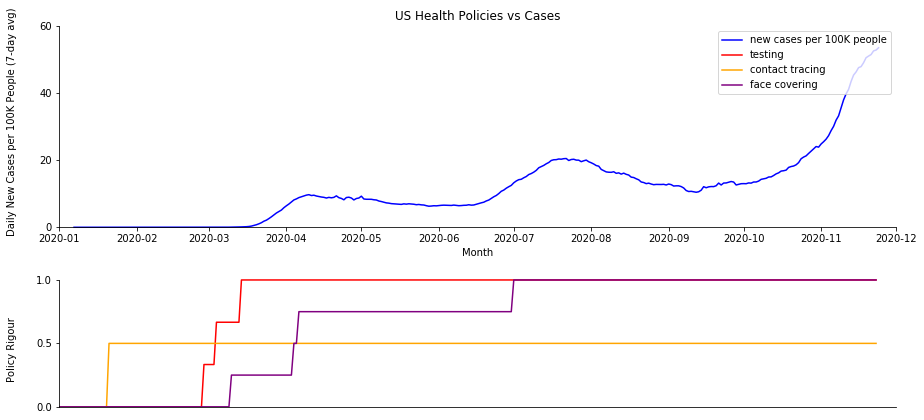

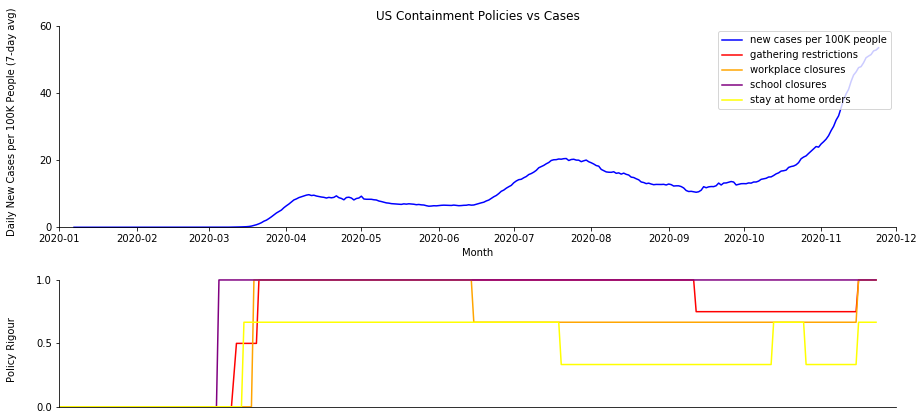

In [8]:
plot_health_policies(us_epi_df, us_gr_df, us_fc_df, us_demo_df, 'US')
plot_containment_policies(us_epi_df, us_gr_df, us_demo_df, 'US')

# Plot Australia Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

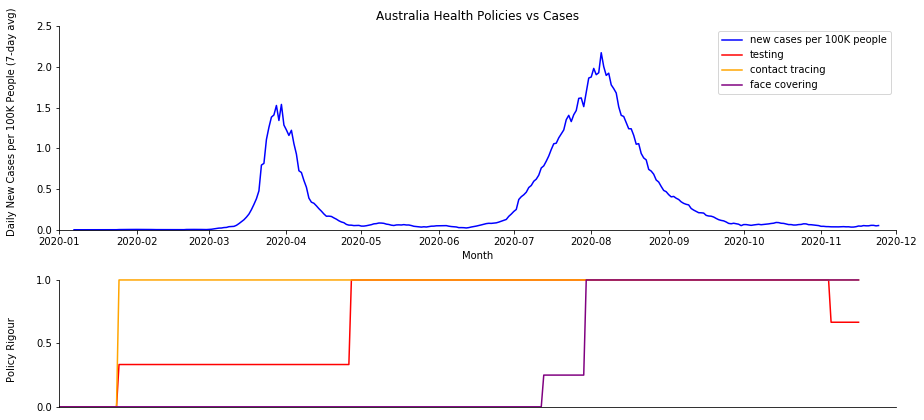

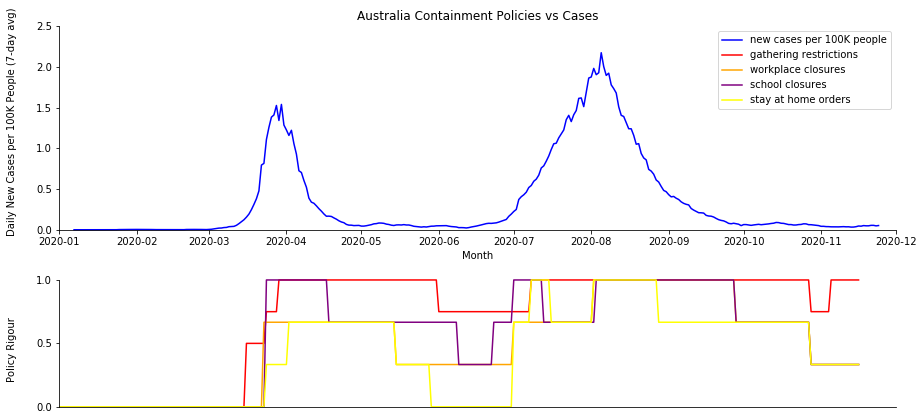

In [9]:
plot_health_policies(au_epi_df, au_gr_df, au_fc_df, au_demo_df, 'Australia')
plot_containment_policies(au_epi_df, au_gr_df, au_demo_df, 'Australia')

# Plot Senegal Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

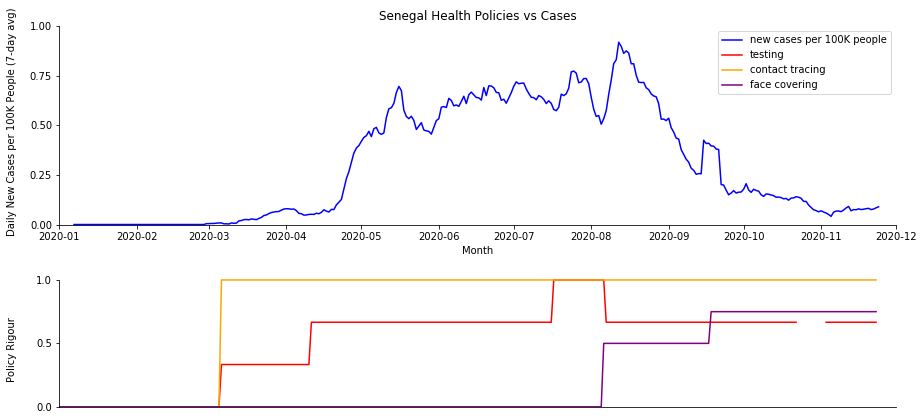

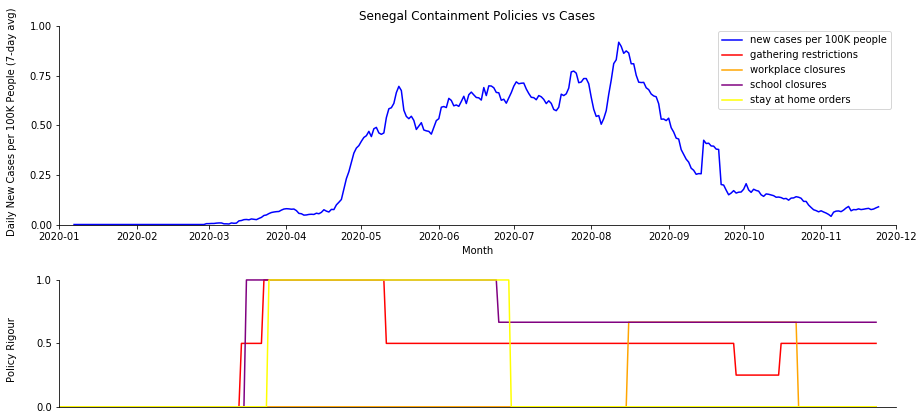

In [10]:
plot_health_policies(sn_epi_df, sn_gr_df, sn_fc_df, sn_demo_df, 'Senegal')
plot_containment_policies(sn_epi_df, sn_gr_df, sn_demo_df, 'Senegal')

# Plot Egypt Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

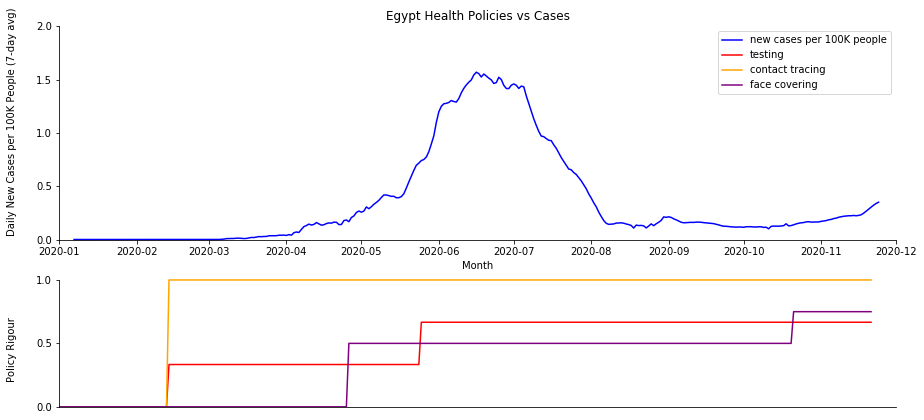

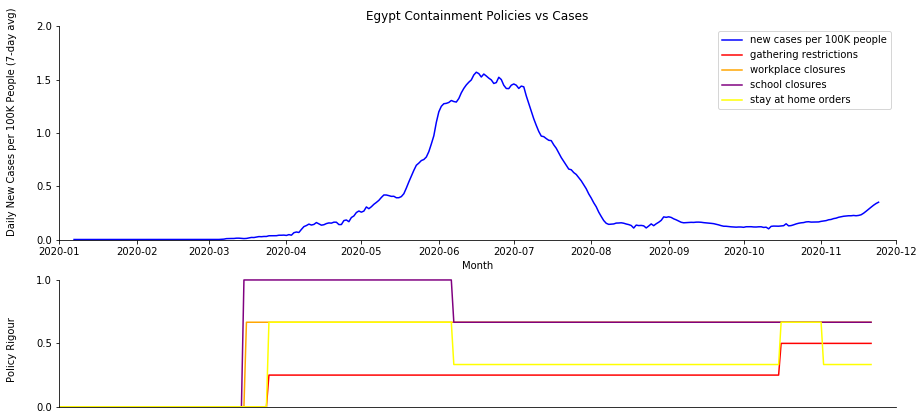

In [11]:
plot_health_policies(eg_epi_df, eg_gr_df, eg_fc_df, eg_demo_df, 'Egypt')
plot_containment_policies(eg_epi_df, eg_gr_df, eg_demo_df, 'Egypt')

# Plot China Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

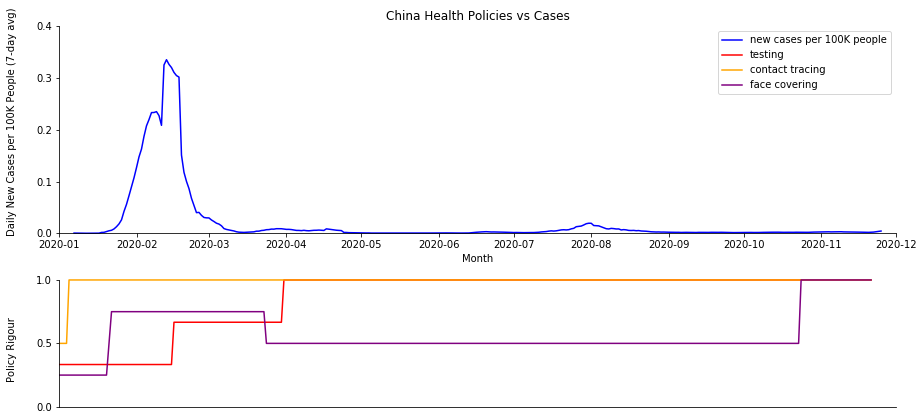

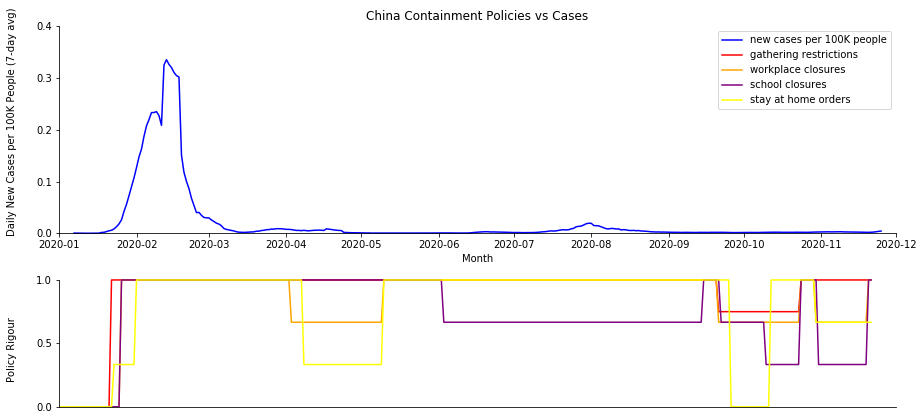

In [12]:
plot_health_policies(cn_epi_df, cn_gr_df, cn_fc_df, cn_demo_df, 'China')
plot_containment_policies(cn_epi_df, cn_gr_df, cn_demo_df, 'China')